In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import itertools
import sqlite3
import os
import pprint
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, recall_score, f1_score
from sklearn.metrics import RocCurveDisplay, roc_curve, roc_auc_score
import matplotlib
import matplotlib.pyplot as plt
from helper import *

pp = pprint.PrettyPrinter(indent=2)

matplotlib.use("nbAgg")
%matplotlib inline

In [3]:
current_folder = os.path.abspath('')
db_file = os.path.join(current_folder, r"data/data.db")
db = sqlite3.connect(db_file)

In [4]:
query = r""" 
    SELECT events, launch_angle, launch_speed, estimated_ba_using_speedangle, hc_x, hc_y, hit_distance_sc, stand, bb_type
    FROM statcast
    WHERE type = 'X' AND
        events NOT LIKE 'sac_%'
"""
raw_data = pd.read_sql_query(query, db)

In [5]:
data = raw_data.copy()
hit_events = {
    'single':1,
    'double':2,
    'triple':3,
    'home_run':4
}

print(data[data.isna().any(axis="columns")].shape[0])

data = data.dropna(axis='index')
data['is_hit'] = np.where(data['events'].isin(hit_events.keys()), 1, 0)
data['bases_earned'] = data.apply(get_bases_earned, axis='columns')
data['spray_angle'] = data.apply(get_spray_angle, axis='columns')

116


# Statcast Predictions

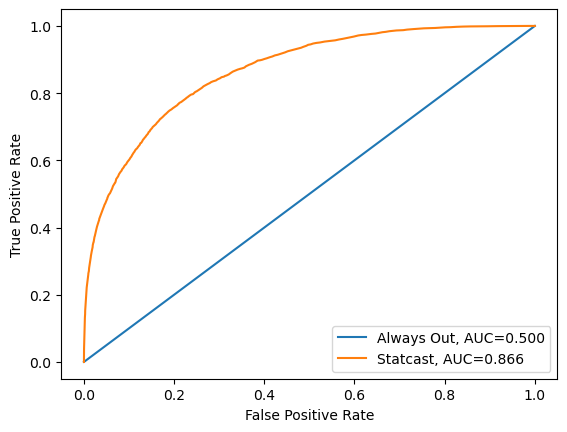

In [6]:
always_out = np.zeros_like(data['is_hit'])
plt.figure(0).clf()

fpr_ao, tpr_ao, _ = roc_curve(data['is_hit'], always_out)
auc_ao = roc_auc_score(data['is_hit'], always_out)
fpr_statcast, tpr_statcast, _ = roc_curve(data['is_hit'], data['estimated_ba_using_speedangle'])
auc_statcast = roc_auc_score(data['is_hit'], data['estimated_ba_using_speedangle'])

plt.plot(fpr_ao, tpr_ao, label=f"Always Out, AUC={auc_ao:0.3f}")
plt.plot(fpr_statcast, tpr_statcast, label=f"Statcast, AUC={auc_statcast:0.3f}")

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend();

            Accuracy  Sensitivity  Specificity  F1 Score
Always Out  0.673498     0.000000     1.000000  0.000000
Statcast    0.802519     0.601721     0.899863  0.665518


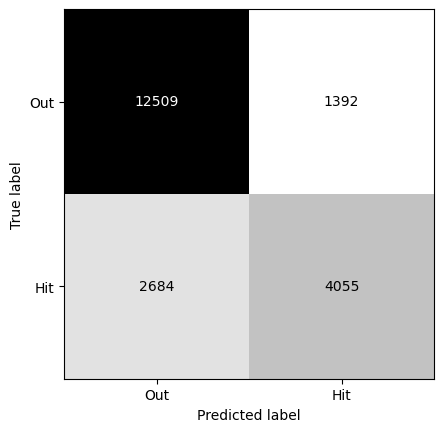

In [7]:
cm_ao = confusion_matrix(data['is_hit'], always_out)
cm_statcast = confusion_matrix(data['is_hit'], np.round(data['estimated_ba_using_speedangle']))

eda_scores = pd.DataFrame([cm_scores(data['is_hit'], always_out), 
                           cm_scores(data['is_hit'], np.round(data['estimated_ba_using_speedangle']))],
                           index=["Always Out", "Statcast"])
print(eda_scores)

ConfusionMatrixDisplay.from_predictions(y_true=data['is_hit'], y_pred=np.round(data['estimated_ba_using_speedangle']),
                                        display_labels=["Out", "Hit"], colorbar=False, cmap="binary");

# Distributions

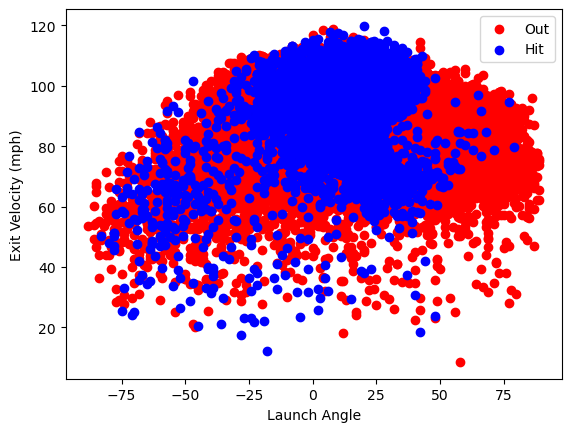

In [8]:
out_data = data[data['is_hit'] == 0]
hit_data = data[data['is_hit'] == 1]
plt.scatter(out_data['launch_angle'], out_data['launch_speed'], c="red",label="Out")
plt.scatter(hit_data['launch_angle'], hit_data['launch_speed'], c="blue",label="Hit")
plt.xlabel("Launch Angle")
plt.ylabel("Exit Velocity (mph)")
plt.legend();

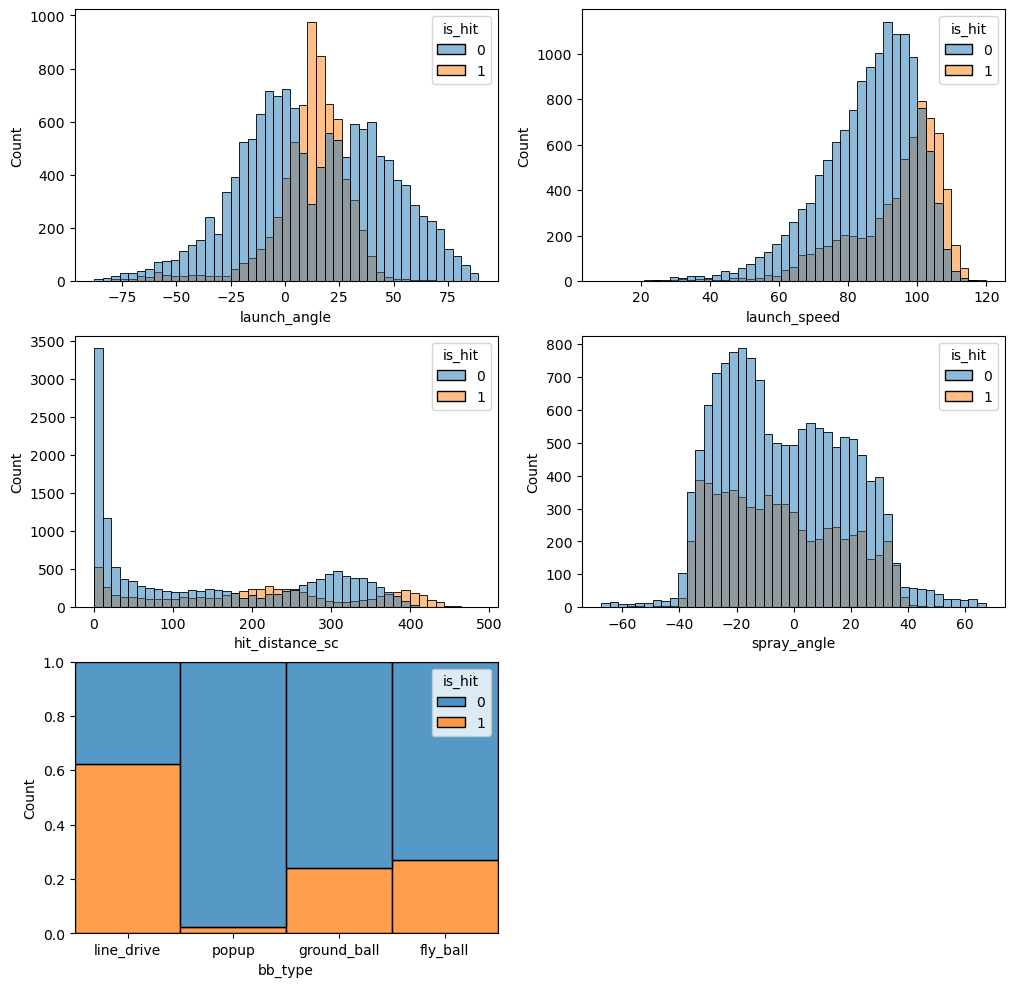

In [9]:
counts_fig = plt.figure(figsize=(12,12))

ax = counts_fig.add_subplot(3,2,1)
sns.histplot(ax=ax, data=data, x='launch_angle', bins=45, hue="is_hit");

ax = counts_fig.add_subplot(3,2,2)
sns.histplot(ax=ax, data=data, x='launch_speed', bins=45, hue="is_hit");

ax = counts_fig.add_subplot(3,2,3)
sns.histplot(ax=ax, data=data, x='hit_distance_sc', bins=45, hue="is_hit");

ax = counts_fig.add_subplot(3,2,4)
sns.histplot(ax=ax, data=data, x='spray_angle', bins=45, hue="is_hit");

ax = counts_fig.add_subplot(3,2,5)
sns.histplot(ax=ax, data=data, x='bb_type', hue="is_hit", stat="count", multiple="fill");
    
    

In [10]:
data_cols = ['launch_speed', 'launch_angle', 'hit_distance_sc', 'spray_angle']
interaction_combos = itertools.combinations(data_cols, 2)
interaction_data = pd.DataFrame()
for combo in interaction_combos:
    interaction_data[combo[0]+"+"+combo[1]] = data.loc[:,combo[0]] * data.loc[:,combo[1]]
interaction_data["is_hit"] = data["is_hit"]
interaction_data["bb_type"] = data["bb_type"]

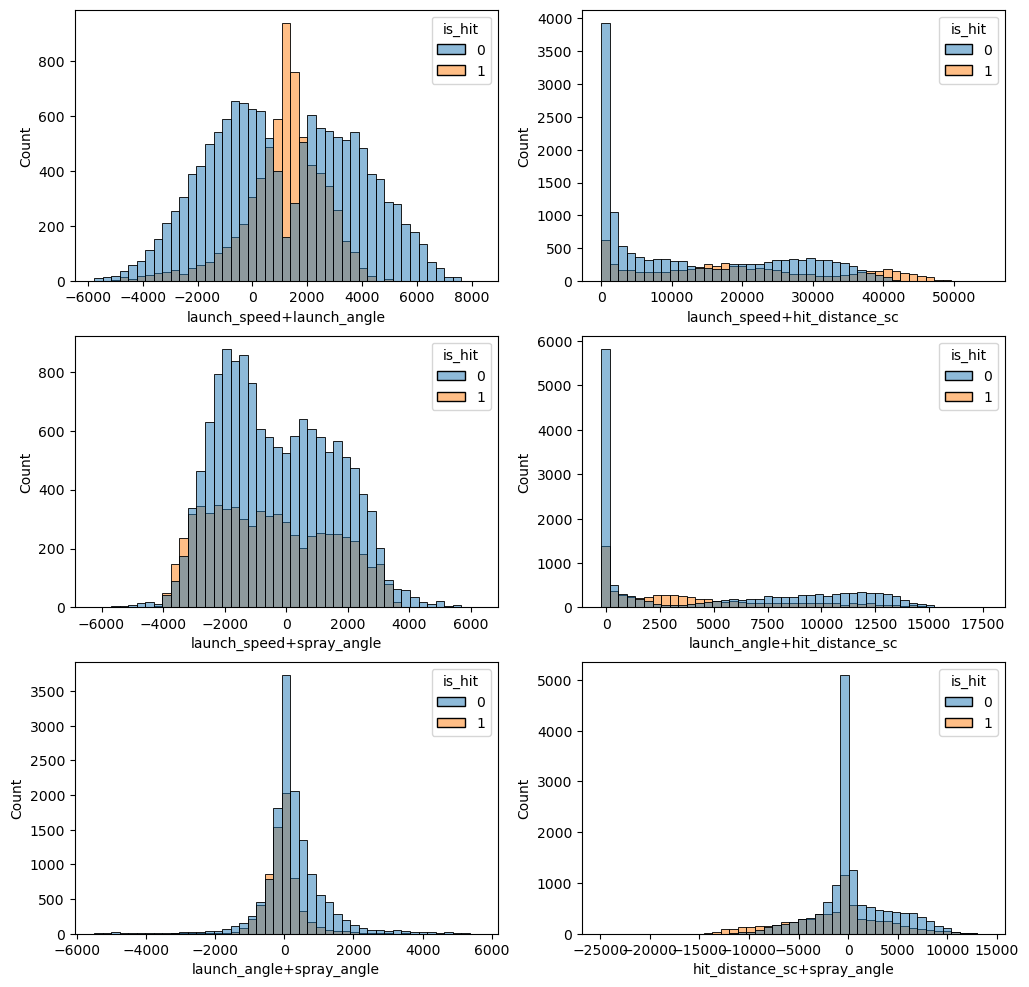

In [11]:
interaction_fig = plt.figure(figsize=(12,12))
for i, col in enumerate(interaction_data.columns):
    if col in ["bb_type", "is_hit"]: continue
    ax = interaction_fig.add_subplot(3,2,i+1)
    sns.histplot(ax=ax, data=interaction_data, x=col, bins=45, hue="is_hit")

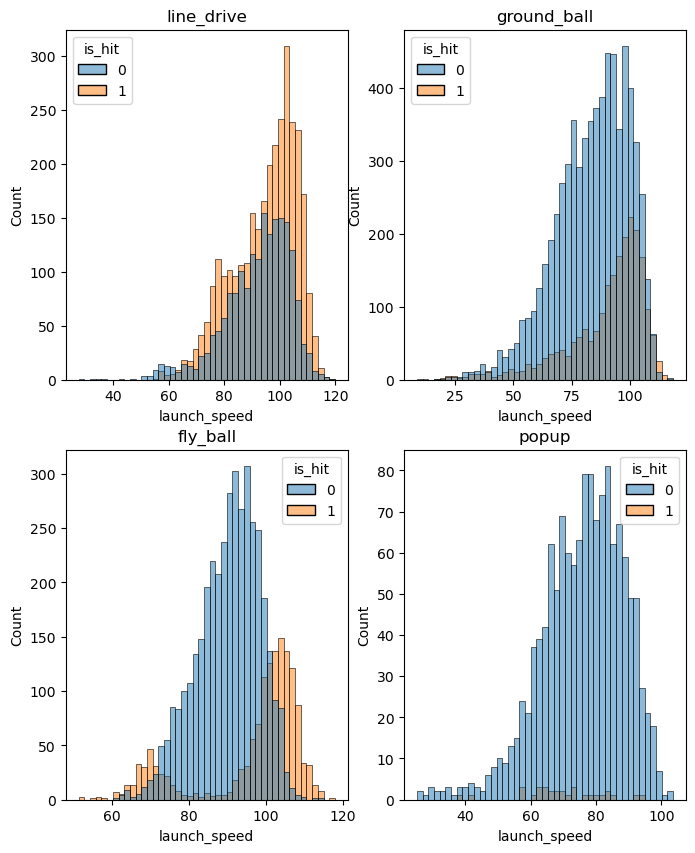

In [12]:
bbtype_fig = plt.figure(figsize=(8,10))
for i,bbtype in enumerate(set(data["bb_type"])):
    bb_data = data[data["bb_type"] == bbtype]
    ax = bbtype_fig.add_subplot(2,2,i+1)
    sns.histplot(ax=ax, data=bb_data, x="launch_speed", bins=45, hue="is_hit").set_title(bbtype)

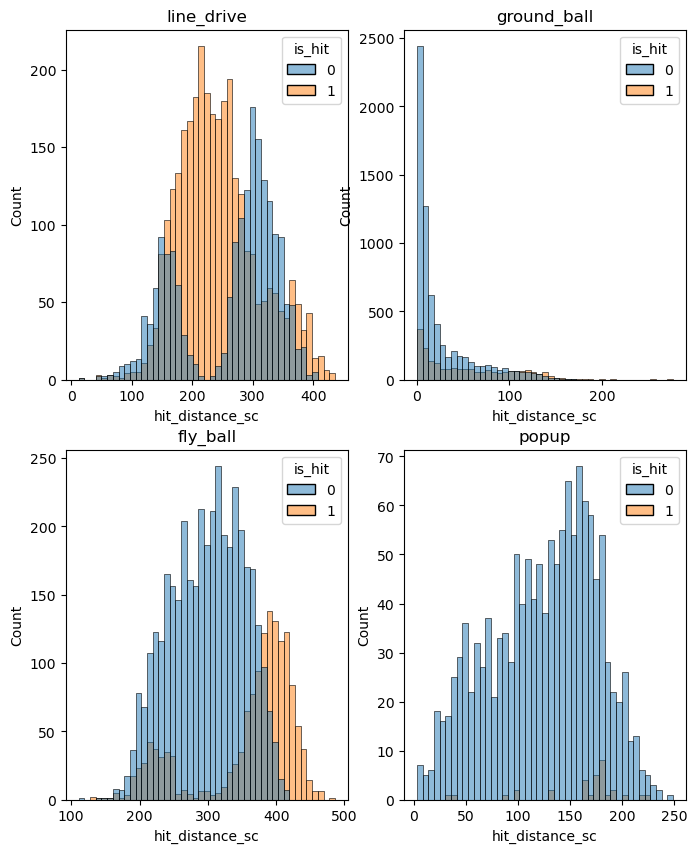

In [13]:
bbtype_fig = plt.figure(figsize=(8,10))
for i,bbtype in enumerate(set(data["bb_type"])):
    bb_data = data[data["bb_type"] == bbtype]
    ax = bbtype_fig.add_subplot(2,2,i+1)
    sns.histplot(ax=ax, data=bb_data, x="hit_distance_sc", bins=45, hue="is_hit").set_title(bbtype)

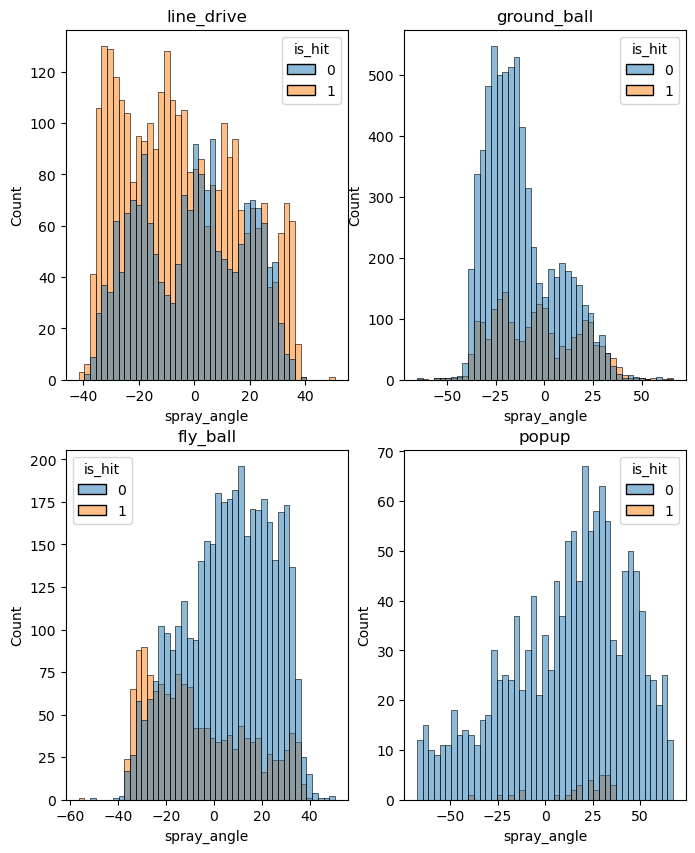

In [14]:
bbtype_fig = plt.figure(figsize=(8,10))
for i,bbtype in enumerate(set(data["bb_type"])):
    bb_data = data[data["bb_type"] == bbtype]
    ax = bbtype_fig.add_subplot(2,2,i+1)
    sns.histplot(ax=ax, data=bb_data, x="spray_angle", bins=45, hue="is_hit").set_title(bbtype)